# 0. Import Libraries

In [1]:
import pandas as pd
import numpy as np
from my_krml_25246568.data.sets import pop_target
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from joblib import dump
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin 
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# 1. Load Data

In [2]:
df = pd.read_csv('../data/processed/processed_data_final.csv', low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13519999 entries, 0 to 13519998
Data columns (total 15 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   startingAirport           float64
 1   destinationAirport        float64
 2   totalTravelDistance       float64
 3   travelDurationMins        float64
 4   cabinTypeSegmentSegment1  float64
 5   cabinTypeSegmentSegment2  float64
 6   cabinTypeSegmentSegment3  float64
 7   cabinTypeSegmentSegment4  float64
 8   numStops                  float64
 9   flightMonth               float64
 10  flightDay                 float64
 11  flightHour                float64
 12  flightMinute              float64
 13  days_difference           float64
 14  totalFare                 float64
dtypes: float64(15)
memory usage: 1.5 GB


In [4]:
df.head()

,startingAirport,destinationAirport,totalTravelDistance,travelDurationMins,cabinTypeSegmentSegment1,cabinTypeSegmentSegment2,cabinTypeSegmentSegment3,cabinTypeSegmentSegment4,numStops,flightMonth,flightDay,flightHour,flightMinute,days_difference,totalFare
0,0.964373,-1.603932,0.710709,0.244224,-0.050707,0.637703,-0.281603,-0.052332,0.377654,-0.621904,0.582158,0.025652,1.695090,0.212696,103.98
1,0.964373,-1.603932,1.025539,-0.193447,-0.050707,0.637703,-0.281603,-0.052332,0.377654,-0.621904,0.582158,-1.200963,1.589283,0.212696,216.58
2,0.964373,-1.603932,1.025539,0.578117,-0.050707,0.637703,-0.281603,-0.052332,0.377654,-0.621904,0.468623,1.497591,-1.108799,0.155061,216.58
3,0.964373,-1.603932,1.025539,-0.184423,-0.050707,0.637703,-0.281603,-0.052332,0.377654,-0.621904,0.582158,0.270975,1.589283,0.212696,237.58
4,0.964373,-1.603932,1.551857,1.958812,-0.050707,0.637703,-0.281603,-0.052332,0.377654,-0.621904,0.582158,0.393637,0.795729,0.212696,307.21


In [5]:
df.shape

(13519999, 15)

# 2. Split Dataset

## [2.1] Sampling dataset

Sampling the dataset based on the origin destination pair, so that all the pairs are included in the sample

In [6]:
# fraction of each group to sample
sample_fraction = 0.3

In [7]:
# Perform stratified sampling by 'startingAirport' and 'destinationAirport'
sampled_df = df.groupby(['startingAirport', 'destinationAirport'], group_keys=False).apply(lambda x: x.sample(frac=sample_fraction))

/var/folders/y7/4mw_ll2n3zz0kzg7v6kt7kwm0000gn/T/ipykernel_22986/1789080720.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(['startingAirport', 'destinationAirport'], group_keys=False).apply(lambda x: x.sample(frac=sample_fraction))


In [8]:
# Reset index
sampled_df = sampled_df.reset_index(drop=True)

In [9]:
sampled_df.shape

(4055994, 15)

## [2.2] Splitting Sampled Data

### Extracting target variable

In [10]:
sampled_df, target = pop_target(sampled_df, 'totalFare')

### Splitting into training and validation

In [11]:
X_train, X_val, y_train, y_val = train_test_split(sampled_df, target, test_size=0.3, random_state=42)

### Splitting validation into validation and testing

In [12]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# 3. Baseline Model

In [13]:
y_mean = y_train.mean()
y_mean

373.7275449062147

In [14]:
y_base = np.full(y_train.shape, y_mean)
print("RMSE on Training Data:", rmse(y_train, y_base))

RMSE on Training Data: 207.56958214011172


In [15]:
y_mean_val = y_val.mean()
y_mean_val

373.6004657962948

In [16]:
y_val_base = np.full(y_val.shape, y_mean_val)
print("RMSE on Validation Data:", rmse(y_val, y_val_base))

RMSE on Validation Data: 207.46660297199577


In [17]:
y_mean_test = y_test.mean()
y_mean_test

374.10224694280083

In [18]:
y_test_base = np.full(y_test.shape, y_mean_test)
print("RMSE on Testing Data:", rmse(y_test, y_test_base))

RMSE on Testing Data: 208.05749828193925


# 4. Decision Tree Model

## [4.1] Model 1

In [19]:
dt_1 = DecisionTreeRegressor()

In [20]:
dt_1.fit(X_train, y_train)

DecisionTreeRegressor()

In [21]:
y_train_pred = dt_1.predict(X_train)
train_rmse = rmse(y_train, y_train_pred)
print("Training RMSE: ",train_rmse)

Training RMSE:  8.22232938919253


In [22]:
y_val_pred = dt_1.predict(X_val)
val_rmse = rmse(y_val, y_val_pred)
print("Validation RMSE: ",val_rmse)

Validation RMSE:  97.77534382309678


## [4.2] Model 2 - Hyperopt

In [27]:
rstate = np.random.default_rng(42)

In [33]:
space = {
    'max_depth': hp.choice('max_depth', range(3, 15, 1)),  # Maximum depth of the tree
    'min_samples_split': hp.uniform('min_samples_split', 0.01, 0.5),  # Minimum fraction of samples required to split a node
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 20, 1)),  # Minimum number of samples required at a leaf node
    'max_features': hp.choice('max_features', [None, 'sqrt', 'log2', 0.5, 0.75]),  # Number of features to consider for splits
    'max_leaf_nodes': hp.choice('max_leaf_nodes', range(10, 1000, 10))  # Maximum number of leaf nodes
}

In [35]:
def objective(space):
    decision_tree = DecisionTreeRegressor(
        max_depth=int(space['max_depth']),
        min_samples_split=space['min_samples_split'],
        min_samples_leaf=int(space['min_samples_leaf']),
        max_features=space['max_features'],
        max_leaf_nodes=int(space['max_leaf_nodes'])
    )
    # Calculate cross-validated RMSE
    neg_rmse = cross_val_score(decision_tree, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error").mean()

    return {'loss': neg_rmse, 'status': STATUS_OK}

In [36]:
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=3,
    rstate=rstate
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:30<00:00, 10.27s/trial, best loss: -177.23368933090418]


In [37]:
print("Best hyperparameters:", best)

Best hyperparameters: {'max_depth': 0, 'max_features': 1, 'max_leaf_nodes': 98, 'min_samples_leaf': 0, 'min_samples_split': 0.35254851142333904}


In [42]:
dt_2 = DecisionTreeRegressor(
    min_samples_split=best['min_samples_split'],
    max_features=best['max_features'],
    max_leaf_nodes=best['max_leaf_nodes']
)

In [43]:
dt_2.fit(X_train, y_train)

DecisionTreeRegressor(max_features=1, max_leaf_nodes=98,
                      min_samples_split=0.35254851142333904)

In [44]:
y_train_pred = dt_2.predict(X_train)
train_rmse = rmse(y_train, y_train_pred)
print("Training RMSE: ",train_rmse)

Training RMSE:  173.6884579285907


In [45]:
y_val_pred = dt_2.predict(X_val)
val_rmse = rmse(y_val, y_val_pred)
print("Validation RMSE: ",val_rmse)

Validation RMSE:  173.73478306974536


## [4.3] Model 3 - Randomised Search

In [46]:
# Define the parameter distribution for DecisionTreeRegressor
param_dist = {
    'max_depth': np.arange(3, 20, 1),  # Range of tree depth to test
    'min_samples_split': np.arange(2, 21, 1),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1, 21, 1),  # Minimum number of samples at a leaf node
    'max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider when looking for the best split
    'max_leaf_nodes': [None] + list(np.arange(10, 200, 10))  # Maximum number of leaf nodes
}

In [47]:
# Create a DecisionTreeRegressor instance
dt_4 = DecisionTreeRegressor(random_state=42)

In [48]:
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dt_4,
    param_distributions=param_dist,
    n_iter=30,  # Number of random combinations to try
    scoring='neg_root_mean_squared_error',  # RMSE scoring for regression
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42
)

In [49]:
# Fit the random search to the data
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/at3-model-experimentation-B62jgcKj-py3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/at3-model-experimentation-B62jgcKj-py3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/at3-model-experimentation-B62jgcKj-py3.11/lib/python3.11/site-packages/sklearn

RandomizedSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42),
                   n_iter=30,
                   param_distributions={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50, 60, 70, 80, 90,
                                                           100, 110, 120, 130,
                                                           140, 150, 160, 170,
                                                           180, 190],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20])},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [50]:
# Output the best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best RMSE score from random search: ", -random_search.best_score_)

Best parameters found:  {'min_samples_split': 5, 'min_samples_leaf': 15, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 13}
Best RMSE score from random search:  130.84938328485154


In [51]:
y_train_pred = random_search.predict(X_train)
train_rmse = rmse(y_train, y_train_pred)
print("Training RMSE: ",train_rmse)

Training RMSE:  129.6622362228212


In [52]:
y_val_pred = random_search.predict(X_val)
val_rmse = rmse(y_val, y_val_pred)
print("Validation RMSE: ",val_rmse)

Validation RMSE:  130.3997177525444


# 5. Feature Importance Graph

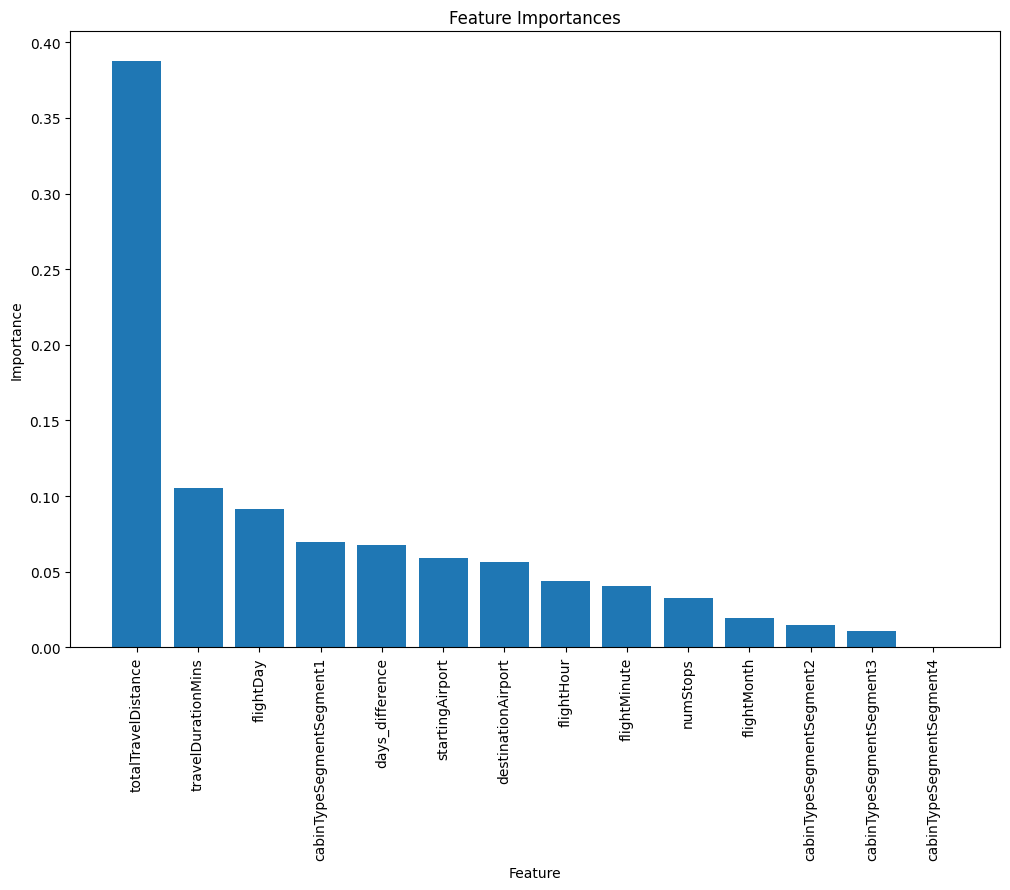

In [53]:
# Get feature importances
feature_importances = dt_1.feature_importances_

# Sort the features by importance
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

# Testing set results for best model

In [54]:
y_test_pred = dt_1.predict(X_test)
test_rmse = rmse(y_test, y_test_pred)
print("Testing RMSE: ",test_rmse)

Testing RMSE:  98.77633646316868
